# Plots for logistic regression, consistent vs inconsistent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio
import matplotlib.lines

import typing
import os
import shutil
import sys
import warnings

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPORT_NAME = 'logistic_regression_inconsistent_consistent'
INCREASING_D_EXPERIMENT_NAME = 'logistic_regression_inconsistent_consistent_increase_d'
INCREASING_EPS_EXPERIMENT_NAME = 'logistic_regression_inconsistent_consistent_increase_epsilon'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 2.0)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPORT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment_d_increase = client.get_experiment_by_name(INCREASING_D_EXPERIMENT_NAME)
experiment_eps_increase = client.get_experiment_by_name(INCREASING_EPS_EXPERIMENT_NAME)

runs_d_increase = mlflow.search_runs(experiment_d_increase.experiment_id)
runs_eps_increase = mlflow.search_runs(experiment_eps_increase.experiment_id)

def prepare_runs(runs: pd.DataFrame) -> pd.DataFrame:
    runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

    # Convert some parameters to numbers and sort accordingly
    runs['params.data_dim'] = runs['params.data_dim'].astype(int)
    runs['params.data_num_train_samples'] = runs['params.data_num_train_samples'].astype(int)
    runs['params.train_attack_epsilon'] = runs['params.train_attack_epsilon'].astype(np.float)
    runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
    runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
    runs['params.label_noise'] = runs['params.label_noise'].astype(np.float)
    runs = runs.sort_values(['params.data_dim', 'params.l2_lambda'])
    assert runs['status'].eq('FINISHED').all()
    return runs

runs_d_increase = prepare_runs(runs_d_increase)
print('Loaded', len(runs_d_increase), 'runs of experiment', INCREASING_D_EXPERIMENT_NAME)
runs_eps_increase = prepare_runs(runs_eps_increase)
print('Loaded', len(runs_eps_increase), 'runs of experiment', INCREASING_EPS_EXPERIMENT_NAME)


Loaded 4920 runs of experiment logistic_regression_inconsistent_consistent_increase_d
Loaded 140 runs of experiment logistic_regression_inconsistent_consistent_increase_epsilon


In [8]:
assert runs_eps_increase['params.l2_lambda'].eq(0).all()
assert runs_eps_increase['params.label_noise'].eq(0).all()
assert runs_d_increase['params.label_noise'].eq(0).all()

In [9]:
grouping_keys = ['params.data_dim', 'params.l2_lambda', 'params.train_consistent_attacks', 'params.train_attack_epsilon', 'params.data_num_train_samples']
aggregate_metrics = ('metrics.true_robust_risk', 'metrics.training_loss')
runs_d_increase_agg = runs_d_increase.groupby(grouping_keys, as_index=False).aggregate({metric: ['mean', 'std'] for metric in aggregate_metrics})
runs_eps_increase_agg = runs_eps_increase.groupby(grouping_keys, as_index=False).aggregate({metric: ['mean', 'std'] for metric in aggregate_metrics})

## Plot

In [10]:
robust_consistent_color_idx = 1
robust_inconsistent_color_idx = 2
noreg_linestyle = '-'
bestreg_linestyle = '--'

BASELINE_LAMBDA = 0

In [11]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

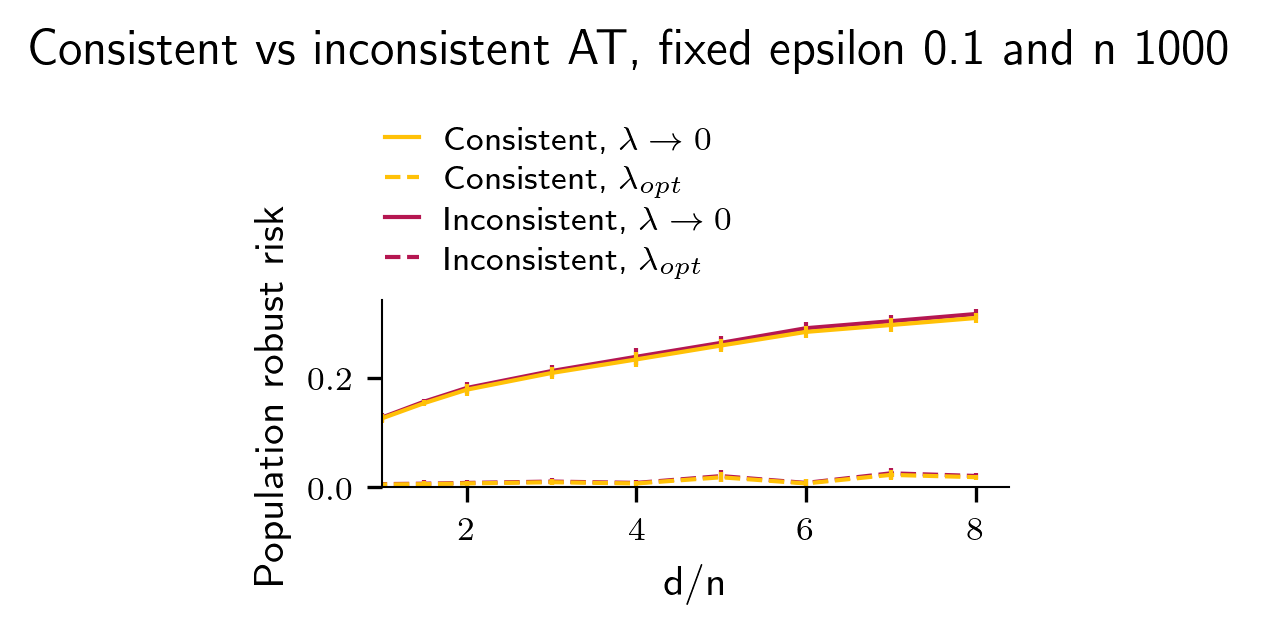

In [12]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

num_samples, = runs_d_increase['params.data_num_train_samples'].unique()
train_attack_epsilon, = runs_d_increase['params.train_attack_epsilon'].unique()

current_consistent_runs = runs_d_increase_agg[runs_d_increase_agg['params.train_consistent_attacks'] == 'True']
current_inconsistent_runs = runs_d_increase_agg[runs_d_increase_agg['params.train_consistent_attacks'] == 'False']

consistent_noreg_runs = current_consistent_runs[current_consistent_runs['params.l2_lambda'] == BASELINE_LAMBDA]
inconsistent_noreg_runs = current_inconsistent_runs[current_inconsistent_runs['params.l2_lambda'] == BASELINE_LAMBDA]

consistent_bestreg_runs = current_consistent_runs.sort_values(('metrics.true_robust_risk', 'mean')).groupby(['params.data_dim'], as_index=False).first()
inconsistent_bestreg_runs = current_inconsistent_runs.sort_values(('metrics.true_robust_risk', 'mean')).groupby(['params.data_dim'], as_index=False).first()

ax.errorbar(
    consistent_noreg_runs['params.data_dim'] / float(num_samples),
    consistent_noreg_runs[('metrics.true_robust_risk', 'mean')],
    yerr=consistent_noreg_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Consistent, $\lambda \to 0$',
    c=f'C{robust_consistent_color_idx}',
    ls=noreg_linestyle,
    zorder=2
)
ax.errorbar(
    consistent_bestreg_runs['params.data_dim'] / float(num_samples),
    consistent_bestreg_runs[('metrics.true_robust_risk', 'mean')],
    yerr=consistent_bestreg_runs[('metrics.true_robust_risk', 'std')],
    label=r'Consistent, $\lambda_{opt}$',
    c=f'C{robust_consistent_color_idx}',
    ls=bestreg_linestyle,
    zorder=2
)

ax.errorbar(
    inconsistent_noreg_runs['params.data_dim'] / float(num_samples),
    inconsistent_noreg_runs[('metrics.true_robust_risk', 'mean')],
    yerr=inconsistent_noreg_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Inconsistent, $\lambda \to 0$',
    c=f'C{robust_inconsistent_color_idx}',
    ls=noreg_linestyle,
    zorder=1
)
ax.errorbar(
    inconsistent_bestreg_runs['params.data_dim'] / float(num_samples),
    inconsistent_bestreg_runs[('metrics.true_robust_risk', 'mean')],
    yerr=inconsistent_bestreg_runs[('metrics.true_robust_risk', 'std')],
    label=r'Inconsistent, $\lambda_{opt}$',
    c=f'C{robust_inconsistent_color_idx}',
    ls=bestreg_linestyle,
    zorder=1
)

ax.set_xlabel('d/n')
ax.set_ylabel('Population robust risk')
ax.set_ylim(bottom=0)
ax.set_xlim(left=1)

legend_loc = (0.0, 1.1)
ir.plots.errorbar_legend(ax, fontsize=LEGEND_FONT_SIZE, loc=legend_loc)

if SHOW_TITLES:
    fig.suptitle(f'Consistent vs inconsistent AT, fixed epsilon {train_attack_epsilon} and n {num_samples}')

export_fig(fig, f'logreg_inconsistent_vs_consistent_d_increase.pdf')

plt.show()

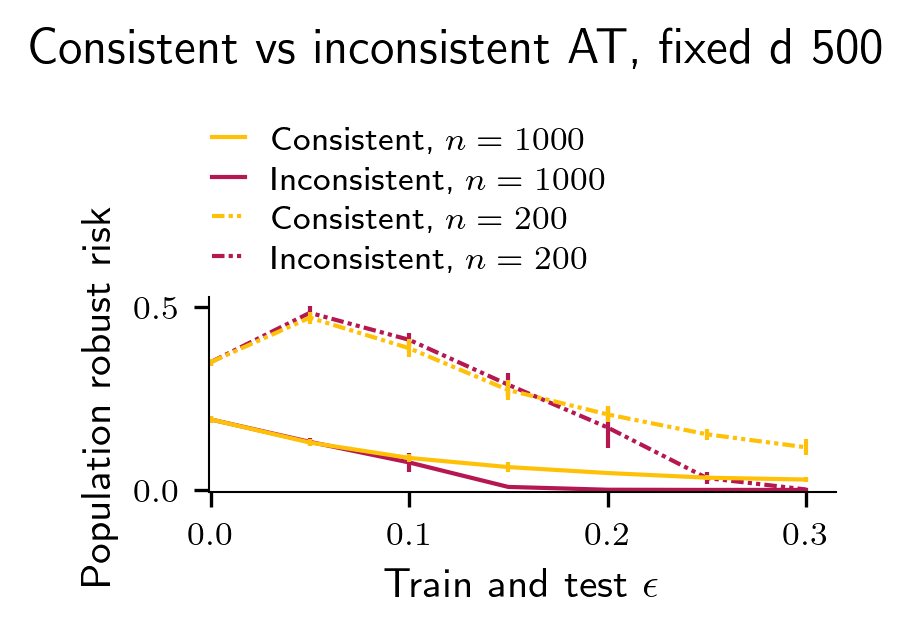

In [13]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

num_samples_map = {
    1000: ir.plots.LINESTYLE_MAP[0],
    200: ir.plots.LINESTYLE_MAP[3]
}

data_dim, = runs_eps_increase['params.data_dim'].unique()

eps_increase_consistent_runs = runs_eps_increase_agg[runs_eps_increase_agg['params.train_consistent_attacks'] == 'True']
eps_increase_inconsistent_runs = runs_eps_increase_agg[runs_eps_increase_agg['params.train_consistent_attacks'] == 'False']

for num_samples, linestyle in num_samples_map.items():
    current_consistent_runs = eps_increase_consistent_runs[eps_increase_consistent_runs['params.data_num_train_samples'] == num_samples]
    current_inconsistent_runs = eps_increase_inconsistent_runs[eps_increase_inconsistent_runs['params.data_num_train_samples'] == num_samples]
    
    ax.errorbar(
        current_consistent_runs['params.train_attack_epsilon'],
        current_consistent_runs[('metrics.true_robust_risk', 'mean')],
        yerr=current_consistent_runs[('metrics.true_robust_risk', 'std')],
        label=fr'Consistent, $n = {num_samples}$',
        c=f'C{robust_consistent_color_idx}',
        ls=linestyle,
        zorder=2
    )
    ax.errorbar(
        current_inconsistent_runs['params.train_attack_epsilon'],
        current_inconsistent_runs[('metrics.true_robust_risk', 'mean')],
        yerr=current_inconsistent_runs[('metrics.true_robust_risk', 'std')],
        label=fr'Inconsistent, $n = {num_samples}$',
        c=f'C{robust_inconsistent_color_idx}',
        ls=linestyle,
        zorder=1
    )

ax.set_xlabel('Train and test $\epsilon$')
ax.set_ylabel('Population robust risk')
ax.set_ylim(bottom=-0.005)
ax.set_xlim(left=-0.001)

legend_loc = (0.0, 1.1)
ir.plots.errorbar_legend(ax, fontsize=LEGEND_FONT_SIZE, loc=legend_loc)

if SHOW_TITLES:
    fig.suptitle(f'Consistent vs inconsistent AT, fixed d {data_dim}')

export_fig(fig, f'logreg_inconsistent_vs_consistent_eps_increase.pdf')

plt.show()

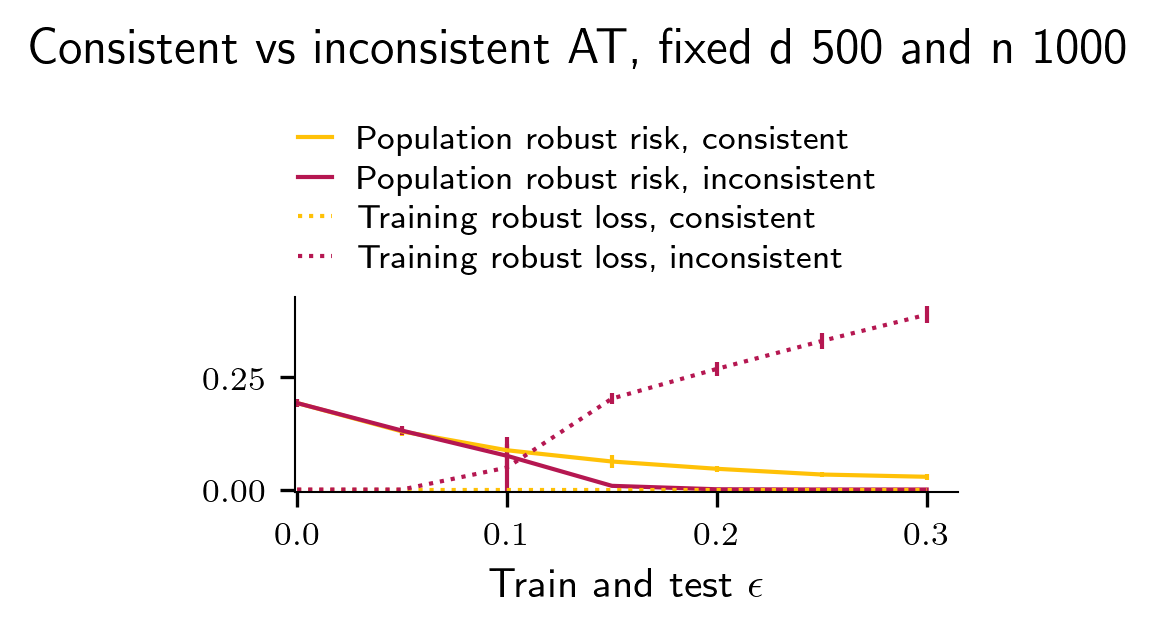

In [14]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

population_linestyle = ir.plots.LINESTYLE_MAP[0]
training_linestyle = ir.plots.LINESTYLE_MAP[2]
target_num_samples = 1000

current_runs = runs_eps_increase_agg[runs_eps_increase_agg['params.data_num_train_samples'] == target_num_samples]
assert current_runs['params.l2_lambda'].eq(0).all()

data_dim, = current_runs['params.data_dim'].unique()

current_consistent_runs = current_runs[current_runs['params.train_consistent_attacks'] == 'True']
current_inconsistent_runs = current_runs[current_runs['params.train_consistent_attacks'] == 'False']

ax.errorbar(
    current_consistent_runs['params.train_attack_epsilon'],
    current_consistent_runs[('metrics.true_robust_risk', 'mean')],
    yerr=current_consistent_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Population robust risk, consistent',
    c=f'C{robust_consistent_color_idx}',
    ls=population_linestyle,
    zorder=2
)
ax.errorbar(
    current_inconsistent_runs['params.train_attack_epsilon'],
    current_inconsistent_runs[('metrics.true_robust_risk', 'mean')],
    yerr=current_inconsistent_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Population robust risk, inconsistent',
    c=f'C{robust_inconsistent_color_idx}',
    ls=population_linestyle,
    zorder=2
)
ax.errorbar(
    current_consistent_runs['params.train_attack_epsilon'],
    current_consistent_runs[('metrics.training_loss', 'mean')],
    yerr=current_consistent_runs[('metrics.training_loss', 'std')],
    label=fr'Training robust loss, consistent',
    c=f'C{robust_consistent_color_idx}',
    ls=training_linestyle,
    zorder=2
)
ax.errorbar(
    current_inconsistent_runs['params.train_attack_epsilon'],
    current_inconsistent_runs[('metrics.training_loss', 'mean')],
    yerr=current_inconsistent_runs[('metrics.training_loss', 'std')],
    label=fr'Training robust loss, inconsistent',
    c=f'C{robust_inconsistent_color_idx}',
    ls=training_linestyle,
    zorder=2
)

ax.set_xlabel('Train and test $\epsilon$')
ax.set_ylim(bottom=-0.005)
ax.set_xlim(left=-0.001)

legend_loc = (0.0, 1.1)
ir.plots.errorbar_legend(ax, fontsize=LEGEND_FONT_SIZE, loc=legend_loc)

if SHOW_TITLES:
    fig.suptitle(f'Consistent vs inconsistent AT, fixed d {data_dim} and n {target_num_samples}')

export_fig(fig, f'logreg_inconsistent_vs_consistent_eps_increase_alt.pdf')

plt.show()